In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, LSTM, TimeDistributed, Reshape
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read Data
data = pd.read_csv('UrbanSounds8K/metadata/UrbanSound8K.csv')
data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
data.shape

(8732, 8)

In [5]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

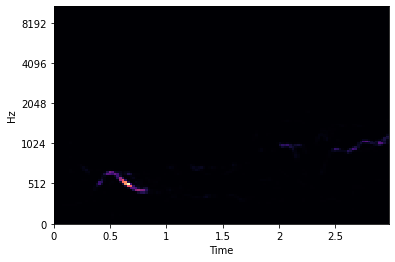

In [6]:
y, sr = librosa.load('UrbanSounds8K/audio/fold9/13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

mel_sgram = librosa.amplitude_to_db(ps, ref=np.min)

librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [7]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [6]:
#Use it to create data ######################################################################
def creates_train_data():
    D = [] # Dataset

    for row in valid_data.itertuples():
        y, sr = librosa.load('UrbanSounds8K/augmented/ps2_m25/' + row.path, duration=2.97)  #2.97 = 3*1000 - 3*1000/128  ###############################
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D.append( (ps, row.classID) )
    np.save('train_data_augmented_ps2_m25.npy', D) ###############################
    return D

In [2]:
#D = creates_train_data()

np.load.__defaults__=(None, True, True, 'ASCII')
D = np.load('train_data_augmented_ps1_2.npy')

Each time if you want to create a new '.npy' file 
MAKE SURE you delete the previous(old) one in the directory!!!! 

In [9]:
print("Number of samples: ", len(D))

Number of samples:  7467


In [10]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [3]:
a = np.load('train_data.npy')
b = np.load('train_data_augmented_speed_81.npy')
c = np.load('train_data_augmented_speed_107.npy')
d = np.load('train_data_augmented_ps1_2.npy')
e = np.load('train_data_augmented_ps2_m25.npy')

In [31]:
np.savez('train.npz',a,b,c,d,e) ############################################################################

Need to remove previous version before save a new 'npz'. Otherwise will have bug

In [32]:
r = np.load('train.npz') ############################################################################

In [ ]:
locals().update(r) ############################################################################

In [4]:
tuple = (a,b,c,d,e)
tuplearr = np.vstack(tuple)
len(tuplearr)

37303

In [5]:
dataset = tuplearr
random.shuffle(dataset)
len(dataset)

37303

In [26]:
kf = KFold(n_splits=10)

count = 0

keras.backend.clear_session()

for train_set, test_set in kf.split(dataset):
    print("-----------breaking line--------------")
    print( "Train dataset(" +str(len(train_set))+"): " + str(train_set), "              Test dataset(" +str(len(test_set))+"): " + str(test_set))

-----------breaking line--------------
Train dataset(33572): [ 3731  3732  3733 ... 37300 37301 37302]               Test dataset(3731): [   0    1    2 ... 3728 3729 3730]
-----------breaking line--------------
Train dataset(33572): [    0     1     2 ... 37300 37301 37302]               Test dataset(3731): [3731 3732 3733 ... 7459 7460 7461]
-----------breaking line--------------
Train dataset(33572): [    0     1     2 ... 37300 37301 37302]               Test dataset(3731): [ 7462  7463  7464 ... 11190 11191 11192]
-----------breaking line--------------
Train dataset(33573): [    0     1     2 ... 37300 37301 37302]               Test dataset(3730): [11193 11194 11195 ... 14920 14921 14922]
-----------breaking line--------------
Train dataset(33573): [    0     1     2 ... 37300 37301 37302]               Test dataset(3730): [14923 14924 14925 ... 18650 18651 18652]
-----------breaking line--------------
Train dataset(33573): [    0     1     2 ... 37300 37301 37302]               

In [27]:
#To see how many samples are in X-train and y-train
kf = KFold(n_splits=10)

count = 0

keras.backend.clear_session()

for train_set, test_set in kf.split(dataset):
     print( train_set, test_set)
     print("-----------breaking line--------------")
     #X_train, X_test, y_train, y_test = dataset[train_set], dataset[test_set]
 
     print('----------------------------')
     count += 1
     print(count)
     print('----------------------------')
 
     X_train,y_train = zip(*dataset[train_set])
     X_test, y_test = zip(*dataset[test_set])
 
     # Reshape for CNN input
     X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
     X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

    #  X_train = np.expand_dims(X_train, axis=3)
    #  X_test = np.expand_dims(X_test, axis=3)
 
     # One-Hot encoding for classes
     y_train = np.array(keras.utils.to_categorical(y_train, 10))
     y_test = np.array(keras.utils.to_categorical(y_test, 10))

 
    #  NAME = "graphic-{}".format(int(time.time()))
    #  tensorboard = TensorBoard(log_dir='logs{}'.format(NAME +  str(count)))
 
 
     model = Sequential()
     input_shape = ( 128, 128, 1)

     model.add(Conv2D(24, (5, 5), strides=(1,1), input_shape = input_shape) )
     model.add(MaxPooling2D((4, 2), strides=(4, 2)))
     model.add(Activation('relu'))
 
     model.add(Conv2D(48, (5, 5), padding="valid"))
     model.add(MaxPooling2D((4, 2), strides=(4, 2)))
     model.add(Activation('relu'))
 
     model.add(Conv2D(48, (5, 5), padding="valid"))
     model.add(Activation('relu'))
 
     model.add(Flatten())
     model.add(Dropout(rate=0.5))
 
     model.add(Dense(64))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.5))

     
     model.add(Reshape((8, 8)))


     model.add(LSTM(units = 50, return_sequences=True)) 
     model.add(LSTM(32))
     model.add(Dense(10))
     model.add(Activation('softmax'))
 
     #convnet = tflearn.DNN(model, tensorboard_dir='log')
 
     model.compile(
 	    optimizer="Adam",
 	    loss="categorical_crossentropy",
 	    metrics=['accuracy']
        )


     model.fit(
 	    x=X_train, 
 	    y=y_train,
        epochs=12,
        batch_size=128,
        validation_data = (X_test, y_test),
 	    # callbacks=[tensorboard]
 	    )
 
     score = model.evaluate(
 	    x=X_test,
 	    y=y_test
        )
 
     print('Test loss:', score[0])
     print('Test accuracy:', score[1])
     break
 

#model.save('SoundClassification_CNNLSTM.model')

    

    


[ 3731  3732  3733 ... 37300 37301 37302] [   0    1    2 ... 3728 3729 3730]
-----------breaking line--------------
----------------------------
1
----------------------------


MemoryError: Unable to allocate 2.05 GiB for an array with shape (33572, 128, 128, 1) and data type float32

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [23]:
filename = ""

#Audio-Convertor
def audioCon(filename):
   from os import path
   from pydub import AudioSegment
   
   # files                                                                         
   src = "Test/{filename}.mp3"
   dst = "Test/{filename}.wav"
   
   # convert wav to mp3                                                            
   sound = AudioSegment.from_mp3(src)
   sound.export(dst, format="wav")

In [ ]:
audioCon()

In [81]:
def prepare(filepath):
    y, sr = librosa.load(filepath, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps.shape
    return ps.reshape(-1, 128, 128, 1)

In [67]:
model = tf.keras.models.load_model("SoundClassification.model")

In [83]:
prediction = model.predict([prepare('Test/airc.wav')])
max = np.amax(prediction)
print(max)
print(prediction)

0.90739536
[[9.0739536e-01 1.0987020e-05 7.2039278e-05 7.7610814e-05 1.3195210e-02
  9.4531840e-03 1.2650190e-07 6.9615506e-02 4.5010489e-05 1.3501685e-04]]
